In [1]:
#%run /Users/hhg/Research/kinematic_lensing/repo/BinnedFit/RotationCurveFit.py
#%run /Users/hhg/Research/kinematic_lensing/repo/BinnedFit/ChainTool.py

import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as constants

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../../../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_KLens)
from KLtool import *
from tfCube2 import TFCube

sys.path.append(dir_BinnedFit)
from binnedFit_utilities import *
from RotationCurveFit import RotationCurveFit, GaussFit_signle
from ChainTool import ChainTool
from Gamma import Gamma

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebook/branch_runs/tfCube2/../../../../KLens


# set parameters

In [2]:
###### set up parameters ######
pars = {}
pars['g1'] = 0.05
pars['g2'] = 0.05
pars['sini'] = 0.5

pars['redshift'] = 0.25

pars['aspect'] = 0.2
pars['half_light_radius'] = 0.5
pars['theta_int'] = 0./180.*np.pi #np.pi/3.

pars['slitWidth'] = 1.0
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 6000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
print(refSDSSspec)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist


###### setup slitAngles to major & minor axes ######

eint_thy = cal_e_int(sini=pars['sini'], q_z=pars['aspect'])
eobs_thy = cal_e_obs(e_int=eint_thy, g1=pars['g1'])
theta_obs = cal_theta_obs(g1=pars['g1'], g2=pars['g2'], theta_int=pars['theta_int'])

slitAng_major_p = theta_obs #0.001 #theta_obs    
slitAng_minor_p = theta_obs + np.pi/2. #np.pi/2. #theta_obs + np.pi/2.


bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

pars['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p])
#pars['slitAngles'] = np.array([slitAng_major_p])


###### find flux_norm ######

flux_norm = find_flux_norm(pars, R=1.5)
print("flux_norm", flux_norm)

avgFlux_per_pix = avgFlux_in_R_per_pix(pars, flux_norm=flux_norm, R=1.5)
print("avgFlux_per_pix", avgFlux_per_pix)


##############################
line_species='Halpha'

2.9999999999999994e-16 erg / (cm2 nm s)
eobs_thy: 0.23450413223140495
slitAng_major_p: 2.726310993906266
slitAng_minor_p: 92.72631099390625
flux_norm 516.3410186767578
avgFlux_per_pix 0.9999999379724022


# generate mock data

In [3]:
###### image ######
GalIM = GalaxyImage(pars=pars, flux_norm=flux_norm)
obsImg, obsImgVariance = GalIM.observation(signal_to_noise=100.)

e_obs = GalIM.distorsion_int
modelImg = GalIM.model(e=e_obs, half_light_radius=pars['half_light_radius'], theta_int=pars['theta_int'], \
                       g1=pars['g1'], g2=pars['g2'])

###### spectra ######
TF = TFCube(pars=pars, line_species=line_species, flux_norm=flux_norm, sky_norm=1.)

modelSpec = TF.model2D(vcirc=TF.Pars.fid['vcirc'], sini=TF.Pars.fid['sini'], \
                       g1=TF.Pars.fid['g1'], g2=TF.Pars.fid['g2'], vscale=TF.Pars.fid['vscale'], \
                       v_0=TF.Pars.fid['v_0'], r_0=TF.Pars.fid['r_0'], theta_int=TF.Pars.fid['theta_int'], \
                       slitAngles=TF.Pars.fid['slitAngles'])

# obsCube = TF.observation3D()
# obsSpec = TF.observation2D(obsCube=obsCube)

###### prepare data_info ######

data_info = {'spec':modelSpec, 
             'image':modelImg,    
             'image_variance': obsImgVariance,
             'spec_variance': TF.skySpec,
             'par_fid': TF.Pars.fid,
             'flux_norm': flux_norm}

# data_info = {'spec':obsSpec, 
#              'image':obsImg,    
#              'image_variance': obsImgVariance,
#              'spec_variance': TF.skySpec}

data_info['lambdaGrid'] = TF.lambdaGrid
data_info['spaceGrid'] = TF.spaceGrid
data_info['line_species'] = line_species
data_info['lambda_emit'] = pars['linelist']['lambda'][pars['linelist']['species']==line_species][0] #656.461 # Halpha [nm]

print('line_species',line_species)
print('lambda_emit',data_info['lambda_emit'])

line_species Halpha
lambda_emit 656.461


In [4]:
GM=Gamma(data_info=data_info, \
         active_par_key=['vcirc', 'sini', 'vscale', 'r_0', 'v_0', 'g1', 'g2', 'half_light_radius','theta_int'])

time cost in gaussFit_spec2D: 0.08144569396972656 (secs)
time cost in gaussFit_spec2D: 0.08670306205749512 (secs)


In [5]:
active_par_fid = np.zeros(len(GM.active_par_key))
for j, item in enumerate(GM.active_par_key):
    active_par_fid[j] = GM.par_fid[item]
active_par_fid

array([2.e+02, 5.e-01, 5.e-01, 0.e+00, 0.e+00, 5.e-02, 5.e-02, 5.e-01,
       0.e+00])

# Check

In [7]:
#active_par_in = active_par_fid.copy()
#active_par_in = np.array([ 200.,  0.5,  0.5,  0., 0., 0., 0.,  0.5, -10./180.*np.pi])
active_par_in=np.array([ 1.96536091e+02,  5.42463379e-01,  7.34027888e-01, -1.46131834e-02,
        5.50775993e-01, -1.77364315e-02, -1.66924452e-03,  5.01150147e-01,
       -2.67695927e-03])
par_in = GM.Pars.gen_par_dict(active_par=active_par_in, active_par_key=GM.active_par_key, par_ref=GM.par_base)

In [8]:
for ind, key in enumerate(GM.active_par_key):
    print(key+": ",active_par_in[ind])

vcirc:  196.536091
sini:  0.542463379
vscale:  0.734027888
r_0:  -0.0146131834
v_0:  0.550775993
g1:  -0.0177364315
g2:  -0.00166924452
half_light_radius:  0.501150147
theta_int:  -0.00267695927


### likelihood

In [9]:
loglike_now = GM.cal_loglike(active_par=active_par_in)
loglike_now

-12.910332725192855

In [10]:
image_out = GM.ImgFit.model_image(sini=par_in['sini'] , half_light_radius=par_in['half_light_radius'], \
                                  theta_int=par_in['theta_int'], g1=par_in['g1'], g2=par_in['g2'])

In [11]:
rot_curve_out = []
for j in range(GM.RotFit.Nspec):
    rot_curve_j = GM.RotFit.model_arctan_rotation(r=GM.RotFit.spec_stats[j]['spaceGrid'], \
                                                vcirc = par_in['vcirc'], \
                                                sini = par_in['sini'], \
                                                vscale=par_in['vscale'], \
                                                r_0=par_in['r_0'], v_0=par_in['v_0'], \
                                                g1=par_in['g1'], g2=par_in['g2'], \
                                                theta_int=par_in['theta_int'], redshift=par_in['redshift'], \
                                                slitAngle=par_in['slitAngles'][j]
                                               )
    rot_curve_out.append(rot_curve_j)

## Image display

Text(0.5, 1.0, 'model at par_in')

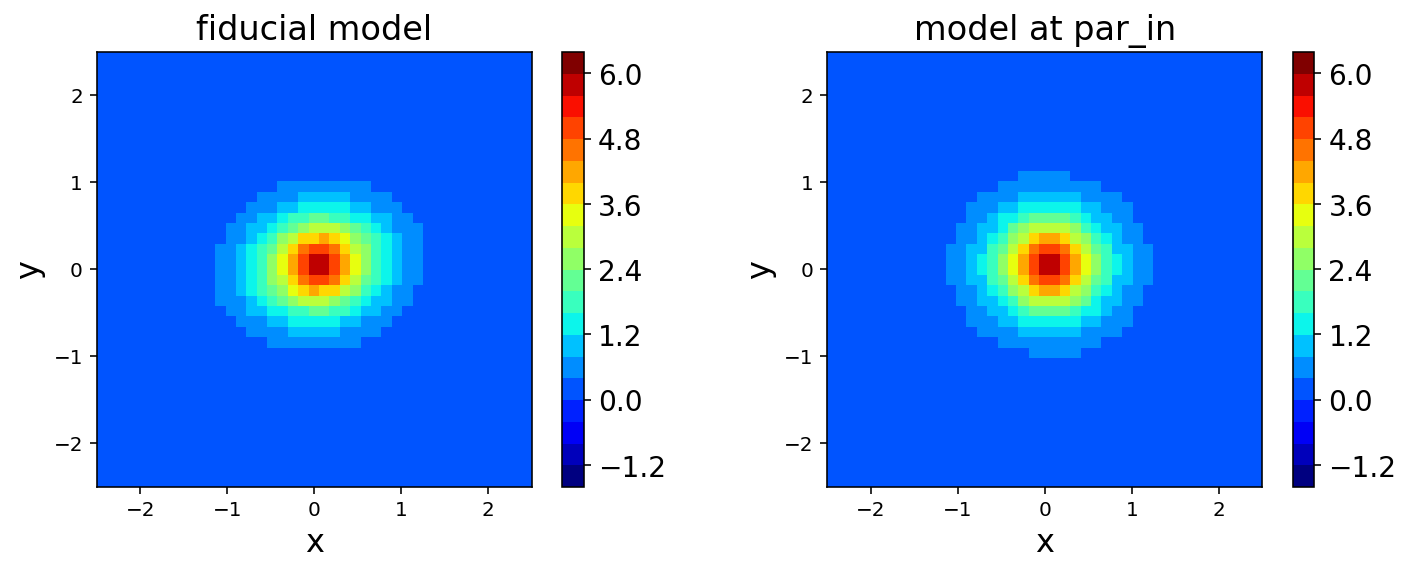

In [12]:
X, Y = np.meshgrid(GalIM.spaceGrid, GalIM.spaceGrid)

fig, ax = plt.subplots(1,2, figsize=(12., 4.))
plt.rc('font',size=14)

levels = MaxNLocator(nbins=20).tick_values(obsImg.min(), obsImg.max())
norm = BoundaryNorm(levels, ncolors=plt.cm.jet.N, clip=True)

galo = ax[0].pcolormesh(X, Y, data_info['image'], cmap=plt.cm.jet, norm=norm)
galm = ax[1].pcolormesh(X, Y, image_out, cmap=plt.cm.jet, norm=norm)

fig.colorbar(galo, ax=ax[0])
fig.colorbar(galm, ax=ax[1])

axixlim = 2.5

for j in range(2):
    ax[j].set_xlim((-axixlim, axixlim))
    ax[j].set_ylim((-axixlim, axixlim))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel('x', fontsize=16)
    ax[j].set_ylabel('y', fontsize=16)

ax[0].set_title('fiducial model')
ax[1].set_title('model at par_in')

## spec display

time cost in gaussFit_spec2D: 0.08185887336730957 (secs)
time cost in gaussFit_spec2D: 0.08473801612854004 (secs)


Text(0.5, 0.98, 'g1=0.05 | g2=0.05 | sini=0.5')

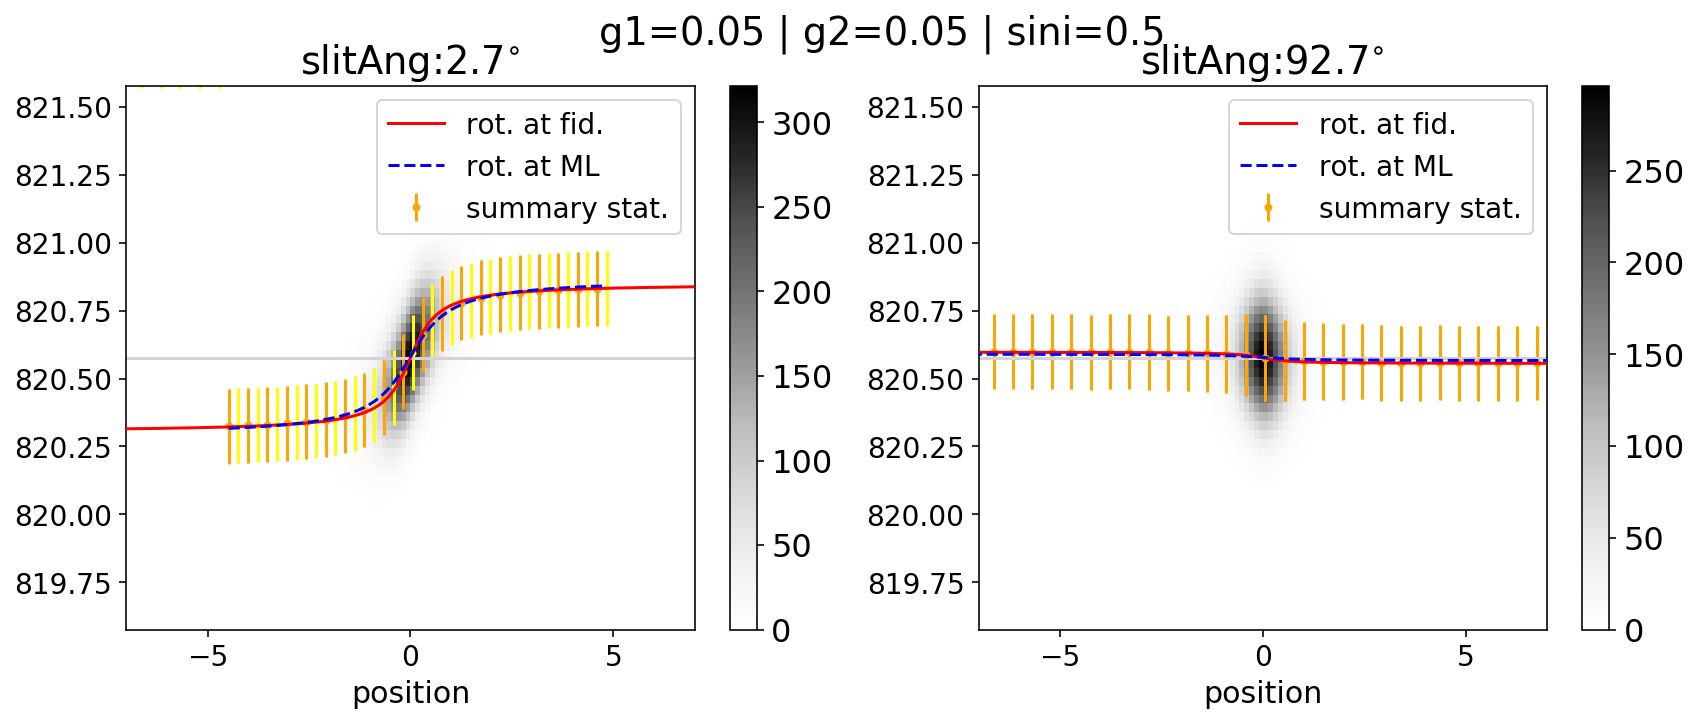

In [13]:

# get pixel edges
lambda_min = np.min(GM.RotFit.lambdaGrid)  ; lambda_MAX = np.max(GM.RotFit.lambdaGrid)
x_min = np.min(GM.RotFit.spaceGrid)        ; x_MAX = np.max(GM.RotFit.spaceGrid)

lambda_emit = GM.RotFit.lambda_emit
lambdaGrid, spaceGrid = GM.RotFit.lambdaGrid, GM.RotFit.spaceGrid

############

fig,ax = plt.subplots(1,2,figsize=(14,5))
plt.rc('font',size=16)

img0=ax[0].imshow(data_info['spec'][0].T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img1=ax[1].imshow(data_info['spec'][1].T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
fig.colorbar(img0, ax=ax[0])
fig.colorbar(img1, ax=ax[1])

## measured summary statstics

for IDsp in range(2):
    GaussFit = GaussFit_signle(spec2D=data_info['spec'][IDsp], lambda_emit=lambda_emit, lambdaGrid=lambdaGrid, spaceGrid=spaceGrid)
    peakLambda, amp, sigma = GaussFit.gaussFit_spec2D(spec2D=data_info['spec'][IDsp])
    peakLambdaG, ampG, sigmaG, spaceGridG = GM.RotFit._remove_0signal_grid(peakLambda, amp, sigma, threshold_SN=1e-10)
    jump = 4
    ax[IDsp].errorbar(spaceGrid[0::jump], peakLambda[0::jump], sigma[0::jump] ,color='yellow', marker='o', markersize=2,ls='none')
    ax[IDsp].errorbar(spaceGridG[0::jump], peakLambdaG[0::jump], sigmaG[0::jump] ,color='orange', marker='o', markersize=3,ls='none',label='summary stat.')
############

## fiducial rotation curve

for IDsp in range(2):
    fidicual_rot = GM.RotFit.model_arctan_rotation(r=spaceGrid, \
                                                   vcirc=GM.par_fid['vcirc'], sini=GM.par_fid['sini'], \
                                                   vscale=GM.par_fid['vscale'], r_0=GM.par_fid['r_0'], v_0=GM.par_fid['v_0'], \
                                                   g1=GM.par_fid['g1'], g2=GM.par_fid['g2'], \
                                                   theta_int=GM.par_fid['theta_int'], redshift=GM.par_fid['redshift'], \
                                                   slitAngle=GM.par_fid['slitAngles'][IDsp])
    
    ax[IDsp].plot(spaceGrid,fidicual_rot,color='r',ls='-',label='rot. at fid.', zorder=10)

#ax[0].plot(GM.RotFit.spec_stats[0]['spaceGrid'],model_major,color='b',ls=':',label='fiducial rot.', zorder=10)
#ax[1].plot(GM.RotFit.spec_stats[1]['spaceGrid'],model_minor,color='b',ls=':',label='fiducial rot.', zorder=10)    


## par_in rotation curve

for IDsp in range(2):
    ax[IDsp].plot(GM.RotFit.spec_stats[IDsp]['spaceGrid'],rot_curve_out[IDsp],color='b',ls='--',label='rot. at ML', zorder=10)
    

###############

lambda_cen = data_info['lambda_emit']*(1.+data_info['par_fid']['redshift'])

for j in range(2):
    ax[j].axhline(lambda_cen, color='lightgray')
    ax[j].set_xlabel('position', fontsize=15)
    
    x_width=7
    ax[j].set_xlim(-x_width,x_width)
    
    y_width=1
    ax[j].set_ylim(lambda_cen-y_width,lambda_cen+y_width)
    
    slitAng_i = pars['slitAngles'][j]*180./np.pi
    ax[j].set_title( f'slitAng:{slitAng_i:.1f}'+'$^{\circ}$' )
    
    ax[j].legend(loc="best",prop={'size':14})


g1=pars['g1']
g2=pars['g2']
sini=pars['sini']

fig.suptitle(f'g1={g1:.2f} | g2={g2:.2f} | sini={sini:.1f}')

# =========== END ===========

In [65]:
GM.RotFit.lambda_emit

656.461

In [66]:
def getPhi_faceOn(theta, sini):

    if sini == 1 or sini == -1: # disk is edge on.
        phi = np.pi
        return phi
    else:
        cosi = np.sqrt(1-sini**2)
        phi = np.arctan2(np.tan(theta), cosi)
        return phi
    
def getTheta_0shear(g1, g2, slitAngle):

    tan_slitAng = np.tan(slitAngle)
    theta_0shear = np.arctan2(-g2+(1+g1)*tan_slitAng, (1-g1)-g2*tan_slitAng)

    return theta_0shear
    
def model_arctan_rotation(r, vcirc, sini, vscale, r_0, v_0, g1, g2, theta_int, redshift, slitAngle):
    lambda_emit = 656.461
    theta_0shear = getTheta_0shear(g1=g1, g2=g2, slitAngle=slitAngle)
    theta_0rotate = theta_0shear - theta_int
    phi = getPhi_faceOn(theta=theta_0rotate, sini=sini)

    if (theta_0rotate > 1.5707963267948966) or (theta_0rotate < 0.):
        R = np.flip(r)
    else :
        R = r

    peak_V = v_0 + 2/np.pi * vcirc * sini * np.cos(phi) * np.arctan((R - r_0)/vscale)
    model_lambda = velocity_to_lambda(v_peculiar=peak_V, lambda_emit=lambda_emit, redshift=redshift)

    return model_lambda

In [67]:
g1=0.
g2=0.
sini=0.99
slitAngle=0.; vcirc = 200. ; vscale=0.5 ; r_0=0. ; v_0=0. ; redshift=0.2 ; theta_int=0.

In [68]:
theta_0shear = getTheta_0shear(g1=g1, g2=g2, slitAngle=slitAngle)
theta_0shear

0.0

In [69]:
theta_0rotate = theta_0shear - theta_int
theta_0rotate

0.0

In [70]:
phi = getPhi_faceOn(theta=theta_0rotate, sini=sini)
phi

0.0

In [71]:
R = 8.
peak_V = v_0 + 2./np.pi * vcirc * sini * np.cos(phi) * np.arctan((R - r_0)/vscale)
peak_V

190.13206437500585

In [72]:
model_lambda = velocity_to_lambda(v_peculiar=peak_V, lambda_emit=lambda_emit, redshift=redshift)
model_lambda

788.2528027689731

In [40]:
    def _getXY_0shear(X, Y, A):
        A_inv = np.linalg.inv(A)
        X_0shear = X*A_inv[0, 0] + Y*A_inv[0, 1]
        Y_0shear = X*A_inv[1, 0] + Y*A_inv[1, 1]
        return X_0shear, Y_0shear
    
    def _getXY_0rotate(X, Y, theta_int):
        X_0rotate = X*np.cos(theta_int) + Y*np.sin(theta_int)
        Y_0rotate = -X*np.sin(theta_int) + Y*np.cos(theta_int)
        return X_0rotate, Y_0rotate
    
    def _getR_faceOn(X, Y, cosi):
        Y_faceOn = Y/cosi
        X_faceOn = X
        R_faceOn = np.sqrt(X_faceOn**2+Y_faceOn**2)
        return R_faceOn

    def _getPhi_faceOn(THETA, sini):
        # This is re-assigning angles in the image plane according to the true inclination of the disk.
        if sini==1 or sini==-1:
            Phi = np.zeros((pars['ngrid'], pars['ngrid']))
            half_ngrid = int(pars['ngrid']/2)
            Phi[:, :half_ngrid] = np.pi
            return Phi
        else:
            cosi = np.sqrt(1-sini**2)
            Phi = np.arctan2(np.sin(THETA)/cosi, np.cos(THETA))
            return Phi

    def getVmap(vcirc, sini, g1, g2, vscale, v_0, r_0, theta_int):
        A = np.array([ [1+g1, g2], [g2, 1-g1] ])
        
        # add shear in the velocity field
        X_0shear, Y_0shear = _getXY_0shear(X=X, Y=Y, A=A)
        X_0rotate, Y_0rotate = _getXY_0rotate(X=X_0shear, Y=Y_0shear, theta_int=theta_int)
        THETA = np.angle(X_0rotate+1j*Y_0rotate)

        R = _getR_faceOn(X=Y_0rotate, Y=Y_0rotate, cosi=cosi)
        PHI = _getPhi_faceOn(THETA=THETA, sini=sini)

        V = v_0 + 2./np.pi * vcirc * sini * np.cos(PHI) * np.arctan((R-r_0)/vscale) 
        return V